In [186]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy
from scipy.sparse import *
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

In [130]:
# parameters
random_state = 42
min_word_frequency = 100

In [131]:
# get all unique tokens in file
def get_words(filename):
    data = open(filename, 'rb')
    res = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        res += line
    return list(set(res))

In [132]:
# join two token lists to token -> id mapping
def get_vocab(words_pos, words_neg):
    all_words = list(set(words_pos + words_neg))
    return {x: i for i, x in tqdm(enumerate(all_words))}

In [133]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename, vocab):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [134]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers, vocab):
    arr = {}
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            p = (i, number)
            if p in arr: arr[p] += 1
            else: arr[p] = 1
                    
    keys = list(arr.keys())
    values = [arr[k] for k in keys]
    return coo_matrix((values, ([x for x, y in keys], [y for x, y in keys])), shape=(len(numbers), len(vocab)))

In [135]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [136]:
# returns vector of token frequencies
def get_word_count(fn, vocab):
    data = open(fn, 'rb')
    res = [0] * len(vocab)
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        for w in line:
            if w in vocab:
                res[vocab[w]] += 1
    return np.array(res)

In [137]:
# obtain dataset from two files using functions above
def get_dataset(tweets_pos, tweets_neg, count_threshold = 100):
    words_pos = get_words(tweets_pos)
    words_neg = get_words(tweets_neg)
    
    vocab = get_vocab(words_pos, words_neg)
    
    # construct num -> word dict
    reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))
    
    # removing non-frequent words from vocab
    word_count = get_word_count(tweets_pos, vocab) + get_word_count(tweets_neg, vocab)
    use_words = [reverse_dictionary[i] for i, x in enumerate(word_count) if x > count_threshold]
    print('Using %d words out of %d' % (len(use_words), len(vocab)))
    vocab = {x: i for i, x in tqdm(enumerate(use_words))}
    # construct num -> word dict
    reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))
    
    # loading data -> numbers of words
    pos_numbers = file_to_word2numbers(tweets_pos, vocab)
    neg_numbers = file_to_word2numbers(tweets_neg, vocab)
    
    # applying it to numbers
    pos_data = numbers_to_dataset(pos_numbers, vocab)
    neg_data = numbers_to_dataset(neg_numbers, vocab)
    
    # applying to datasets (pos & neg)
    X, Y = two_datasets_to_one(pos_data, neg_data)
    return vocab, reverse_dictionary, X, Y

In [189]:
# get full dataset
vocab_full, rev_full, X_full, Y_full = get_dataset('../tmp/clean_train_pos.txt', '../tmp/clean_train_neg.txt', min_word_frequency)
vocab, reverse_dictionary, X, Y = vocab_full, rev_full, X_full, Y_full

1126104it [00:02, 405064.74it/s]
1117611it [00:02, 464849.90it/s]
194282it [00:00, 1008723.07it/s]
1126104it [00:07, 159910.73it/s]
1117611it [00:08, 135294.35it/s]
12102it [00:00, 1241852.20it/s]
6711it [00:00, 67085.59it/s]

Using 12102 words out of 194282


1126104it [00:08, 133537.42it/s]
1117611it [00:09, 117170.08it/s]
1126052it [00:11, 97452.03it/s]
1117574it [00:13, 82487.55it/s]


In [190]:
# get partial dataset
#vocab_part, rev_part, X_part, Y_part = get_dataset('../data/train_pos.txt', '../data/train_neg.txt', min_word_frequency)
#vocab, reverse_dictionary, X, Y = vocab_part, rev_part, X_part, Y_part

In [191]:
# plot word length distribution
def plot_word_count_hist(vocab):
    lengths = [len(x) for x in vocab.keys()]
    pd.DataFrame(lengths).hist()

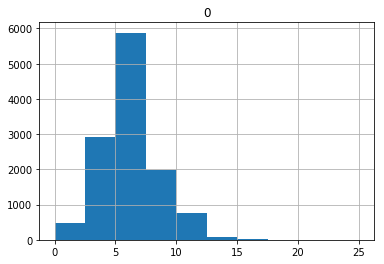

In [192]:
plot_word_count_hist(vocab)

In [193]:
# split to train/val
test_size_percent = 0.01
x, x_val, y, y_val = train_test_split(X, Y, test_size=test_size_percent, random_state=random_state)

In [194]:
y = np.array(y).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)

In [240]:
def batch_generator(X, y, batch_size, number_of_batches):
    counter = 0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter = 0

In [ ]:
# training parameters
hidden_layers = (200, 50, 20)

In [ ]:
model = Sequential()

np.random.seed(random_state)

# first hidden layer
model.add(Dense(hidden_layers[0], activation='relu', input_dim=x.shape[1]))

# adding regularization
model.add(Dropout(0.1))

# hidden layers
for neurons_n in hidden_layers[1:]:
    model.add(Dense(neurons_n, activation='relu'))
    model.add(Dropout(0.1))

# two for classification
model.add(Dense(2, activation='relu'))
    
#output layer
model.add(Dense(1, activation='sigmoid'))

# showing accuracy
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# setting parameters
batch_size = 10000
nb_epoch = 10
nb_batches = x.shape[0] / batch_size
generator = batch_generator(x, y, batch_size, nb_batches)

# training model
model.fit_generator(generator = generator, epochs = nb_epoch, 
                    steps_per_epoch = nb_batches, validation_data=(x_val.toarray(), y_val))
#validation_split=test_size_percent

Epoch 1/10


In [275]:
def to_array_if_sparse(x):
    if type(x) is scipy.sparse.csr.csr_matrix:
        return x.toarray()
    return x

In [276]:
def predict(model, x, sz = 500):
    res = []
    N = x.shape[0]
    batches = N // sz
    if batches * sz < N:
        batches += 1
    for batch in tqdm(range(batches)):
        res += list(model.predict(to_array_if_sparse(x[batch * sz:(batch + 1) * sz,:])).flatten())
    return np.array(res).flatten()

In [277]:
def score(model, x, y):
    return np.mean((predict(model, x).flatten() > 0.5) == y.flatten())

In [260]:
# print resulting train/val losses
print('Accuracy on test: %.3f, on validation: %.3f' % (score(model, x, y), score(model, x_val, y_val)))

  0%|          | 22/4443 [00:02<06:55, 10.64it/s]


KeyboardInterrupt: 

In [263]:
# plot ROC curve
def plot_ROC(x, y, model):
    fpr, tpr, _ = roc_curve(y, predict(model, x))
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 45/45 [00:04<00:00, 11.07it/s]


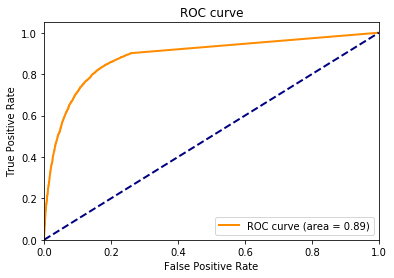

In [278]:
plot_ROC(x_val, y_val, model)

In [279]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((len(vocab), ), dtype=np.float32)
        
        for word in line:
            if word in vocab:
                tweet_embeddings[vocab[word]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == len(vocab)
    return idxes, tweets_embeddings

In [288]:
# write resulting clf predictions to output_filename
# using filename as tweets input (test)
def write_result(filename, clf, output_filename):
    idx_test, X_test = test_to_dataset(filename)
    y_predicted = np.array(2 * ((predict(clf, X_test) > 0.5) - 0.5), dtype=np.int64)
    answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))
    f = open(output_filename, 'w')
    f.write("Id,Prediction\n")
    for idx, ans in answers:
        f.write("%s,%s\n" % (idx, ans))
    f.close()

In [289]:
write_result('../data/test_data.txt', model, 'submission_count_full_nn_cleaned.txt')

10000it [00:00, 20067.60it/s]
100%|██████████| 20/20 [00:01<00:00, 16.71it/s]


In [283]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:00, 15673.99it/s]


2.0

In [287]:
predict(model, X_test)

100%|██████████| 20/20 [00:01<00:00, 16.77it/s]


array([ 0.15502578,  0.48338649,  0.15502578, ...,  0.63053548,
        0.89301348,  0.15502578], dtype=float32)